# Link prediction 

In this NB, we use the embeddings generated in the NB:
`Graph embedding using SkipGram 20201012 homogeneous graph training.ipynb`
md5 hash: 261f9f7b0137263728c292a1a878d7baf3f875f3

kg-covid-19:
version 20201012

ensmallen-graph
Version: 0.4.4

embiggen
Version: 0.6.0

In [1]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')  # identical to 0.4.3 except for addition of some methods like get_edge_id()
assert(get_distribution("embiggen").version == '0.6.0')

### Define all files and URLs up top here

In [2]:
import os

exp_name = "80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001"

s3_path = "s3://kg-hub-public-data/embeddings/20201012/"  # keep trailing slash

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201012")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201012")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201012/SkipGram_80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# params
seed = 42
train_percentage = 0.8
patience = 5
min_delta = 0.0001

In [3]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

In [4]:
# get the graphs, if necessary

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

## Retrieve the embeddings

In [5]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

## Edge embeddings
We will compute the edge embeddings using all the 5 available methods:

- Hadamart: an element-wise product
- Mean
- Norm L1
- Norm L2
- Concatenation

## Defining a simple Feed Forward Neural Network

In [6]:
import os

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Recall, Precision

def build_link_prediction_model(input_shape:int):
    model = Sequential([
        Input(input_shape),
        Dense(128, activation="relu"),
        Dense(32, activation="relu",
              activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.5),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=[
            AUC(curve="PR", name="auprc"),
            AUC(curve="ROC", name="auroc"),
            Recall(name="Recall"),
            Precision(name="Precision"),            
            "accuracy"
        ]
    )
    return model

## Loading the graph

In [8]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = edges_file,
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = nodes_file,
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.07 ms


In [9]:
from ensmallen_graph import EnsmallenGraph
 
graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=447766,  # should be = or > than actual number
    edges_number=42000000,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

{'edges_number': '31223434',
 'nodes_number': '447766',
 'self_loops_rate': '0.000015373068830289457',
 'singletons': '8355',
 'density': '0.010673045865565448',
 'name': 'Graph',
 'directed': 'false',
 'self_loops_number': '480',
 'unique_edge_types_number': '0',
 'has_node_types': 'true',
 'unique_node_types_number': '42',
 'has_edge_types': 'false',
 'has_weights': 'false',
 'undirected_edges_number': '15611957',
 'degree_mean': '69.73158748096104'}

## Defining holdouts and tasks data generator
We are going to create the same edge embeddings as in the training of the embeddings.

In [10]:
%%time
# to use a given edge_type in positive edges:
# install latest ensmallen_graph
# use edge_types param (a list of strings) - validation set will be only these edge types
pos_training, pos_validation = graph.connected_holdout(train_size=train_percentage, random_state=seed)

CPU times: user 3min 14s, sys: 472 ms, total: 3min 14s
Wall time: 3min 13s


In [11]:
%%time
coherence_check=False
if coherence_check:
    assert graph.contains(pos_training)
    assert graph.contains(pos_validation)
    assert (pos_training | pos_validation).contains(graph)
    assert graph.contains(pos_training | pos_validation)
    assert not pos_training.overlaps(pos_validation)

    assert not pos_validation.overlaps(pos_training)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [12]:
import numpy as np
embedding = np.load(embedding_file, allow_pickle=True)
assert(len(embedding) == len(pos_training.get_node_types()))

In [13]:
%%time
# To force neg edges to use nodes from a given graph
# install latest ensmallen
# seed_graph param - upload TSV with this great
neg_training, neg_validation = graph.sample_negatives(
   random_state=seed,
   only_from_same_component=True,
   negatives_number=graph.get_edges_number(),
   # allow_selfloops=False  # this has been removed in new ensmallen - this will instead be inferred from the graph itself
).random_holdout(random_state=seed, train_size=train_percentage)

CPU times: user 8min 6s, sys: 1min 28s, total: 9min 34s
Wall time: 6min 52s


In [14]:
%%time
# To force neg edges to use nodes from a given graph
# install latest ensmallen
# seed_graph param - upload TSV with this great
neg_training_old, neg_validation_old = graph.sample_negatives(
   random_state=seed,
   only_from_same_component=False,
   negatives_number=graph.get_edges_number(),
   # allow_selfloops=False  # this has been removed in new ensmallen - this will instead be inferred from the graph itself
).random_holdout(random_state=seed, train_size=train_percentage)

CPU times: user 5min 42s, sys: 1min 19s, total: 7min 2s
Wall time: 4min 42s


In [15]:
from tqdm.auto import tqdm
from glob import glob
from embiggen import GraphTransformer, EdgeTransformer
import numpy as np
import pandas as pd

def task_generator(
    pos_training:EnsmallenGraph,
    pos_validation:EnsmallenGraph,
    neg_training:EnsmallenGraph,
    neg_validation:EnsmallenGraph,
    train_percentage:float=train_percentage,
    seed:int=seed
):
    """Create new generator of tasks.

    Parameters
    ----------------------------------
    pos_training:EnsmallenGraph,
        The positive edges of the training graph.
    pos_validation:EnsmallenGraph,
        The positive edges of the validation graph.
    neg_training:EnsmallenGraph,
        The negative edges of the training graph.
    neg_validation:EnsmallenGraph,
        The negative edges of the validation graph.
    train_percentage:float=0.8,
    seed:int=42

    """
    for path in tqdm(glob(os.path.join(embedding_data_dir, "*embedding.npy")), desc="Embedding"):
        model_name = os.path.basename(path).split("_")[0]
        embedding = np.load(path, allow_pickle=True)
        for method in tqdm(EdgeTransformer.methods, desc="Methods", leave=False):

            # create graph transformer object to convert graphs into edge embeddings
            transformer = GraphTransformer(method)
            transformer.fit(embedding) # pass node embeddings to be used to create edge embeddings
            train_edges = np.vstack([ # computing edge embeddings for training graph
                transformer.transform(graph)
                for graph in (pos_training, neg_training)
            ])
            valid_edges = np.vstack([ # computing edge embeddings for validation graph
                transformer.transform(graph)
                for graph in (pos_validation, neg_validation)
            ])
            train_labels = np.concatenate([ # make labels for training graph
                np.ones(pos_training.get_edges_number()),
                np.zeros(neg_training.get_edges_number())
            ])
            valid_labels = np.concatenate([ # make labels for validation graph
                np.ones(pos_validation.get_edges_number()),
                np.zeros(neg_validation.get_edges_number())
            ])
            train_indices = np.arange(0, train_labels.size)
            valid_indices = np.arange(0, valid_labels.size)
            np.random.shuffle(train_indices) # shuffle to prevent bias caused by ordering of edge labels
            np.random.shuffle(valid_indices) # ``   ``
            train_edges = train_edges[train_indices]
            train_labels = train_labels[train_indices]
            valid_edges = valid_edges[valid_indices]
            valid_labels = valid_labels[valid_indices]
            yield model_name, method, (train_edges, train_labels), (valid_edges, valid_labels)

## Training the models

In [16]:
import os
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from notipy_me import Notipy, KerasNotipy

histories = {}
strategy = MirroredStrategy()
os.makedirs("classical_link_prediction", exist_ok=True)

for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
    history_path = f"classical_link_prediction/{embedding_model}_{method}.csv"
    if os.path.exists(history_path):
        histories[(embedding_model, method)] = pd.read_csv(history_path)
        continue
    with strategy.scope():
        model = build_link_prediction_model(train[0].shape[1:])
        
        history = pd.DataFrame(model.fit(
            *train,
            batch_size=2**12,
            validation_data=valid,
            epochs=1000,
            callbacks=[
                EarlyStopping("val_loss", patience=patience, min_delta=min_delta),
                # ReduceLROnPlateau(),
                # KerasNotipy(task_name="LR 20201012")
            ]
        ).history)

        history.to_csv(history_path, index=False)
        histories[(embedding_model, method)] = history
        
        h5_file = f"{embedding_model}_{exp_name}_{method}_finalized_model.h5"
        model.save(h5_file)
        os.system(f"s3cmd put --acl-public --cf-invalidate {h5_file} {s3_path}")


Epoch 1/1000
12197/12197 [==============================] - 169s 14ms/step - loss: 0.4461 - auprc: 0.8683 - auroc: 0.8473 - Recall: 0.7712 - Precision: 0.8654 - accuracy: 0.8256 - val_loss: 0.4829 - val_auprc: 0.8813 - val_auroc: 0.8565 - val_Recall: 0.6768 - val_Precision: 0.9132 - val_accuracy: 0.8062
Epoch 2/1000
12197/12197 [==============================] - 147s 12ms/step - loss: 0.4312 - auprc: 0.8762 - auroc: 0.8526 - Recall: 0.7668 - Precision: 0.8777 - accuracy: 0.8300 - val_loss: 0.4794 - val_auprc: 0.8824 - val_auroc: 0.8572 - val_Recall: 0.6644 - val_Precision: 0.9192 - val_accuracy: 0.8030
Epoch 3/1000
12197/12197 [==============================] - 143s 12ms/step - loss: 0.4277 - auprc: 0.8787 - auroc: 0.8538 - Recall: 0.7653 - Precision: 0.8816 - accuracy: 0.8313 - val_loss: 0.4853 - val_auprc: 0.8829 - val_auroc: 0.8576 - val_Recall: 0.6419 - val_Precision: 0.9246 - val_accuracy: 0.7948
Epoch 4/1000
12197/12197 [==============================] - 142s 12ms/step - loss: 0.

Epoch 11/1000
12197/12197 [==============================] - 136s 11ms/step - loss: 0.4470 - auprc: 0.8533 - auroc: 0.8393 - Recall: 0.7784 - Precision: 0.8624 - accuracy: 0.8271 - val_loss: 0.4434 - val_auprc: 0.8560 - val_auroc: 0.8423 - val_Recall: 0.7841 - val_Precision: 0.8635 - val_accuracy: 0.8301
Epoch 12/1000
12197/12197 [==============================] - 134s 11ms/step - loss: 0.4471 - auprc: 0.8533 - auroc: 0.8393 - Recall: 0.7784 - Precision: 0.8625 - accuracy: 0.8271 - val_loss: 0.4432 - val_auprc: 0.8561 - val_auroc: 0.8424 - val_Recall: 0.7841 - val_Precision: 0.8635 - val_accuracy: 0.8301
Epoch 13/1000
12197/12197 [==============================] - 135s 11ms/step - loss: 0.4470 - auprc: 0.8534 - auroc: 0.8394 - Recall: 0.7783 - Precision: 0.8625 - accuracy: 0.8271 - val_loss: 0.4431 - val_auprc: 0.8559 - val_auroc: 0.8423 - val_Recall: 0.7841 - val_Precision: 0.8636 - val_accuracy: 0.8301
Epoch 14/1000
12197/12197 [==============================] - 134s 11ms/step - loss

Epoch 38/1000
12197/12197 [==============================] - 135s 11ms/step - loss: 0.4158 - auprc: 0.8904 - auroc: 0.8620 - Recall: 0.7719 - Precision: 0.8804 - accuracy: 0.8335 - val_loss: 0.4120 - val_auprc: 0.8973 - val_auroc: 0.8668 - val_Recall: 0.7832 - val_Precision: 0.8717 - val_accuracy: 0.8340
Epoch 39/1000
12197/12197 [==============================] - 138s 11ms/step - loss: 0.4154 - auprc: 0.8906 - auroc: 0.8623 - Recall: 0.7722 - Precision: 0.8808 - accuracy: 0.8339 - val_loss: 0.4120 - val_auprc: 0.8972 - val_auroc: 0.8669 - val_Recall: 0.7832 - val_Precision: 0.8726 - val_accuracy: 0.8344
Epoch 40/1000
12197/12197 [==============================] - 134s 11ms/step - loss: 0.4151 - auprc: 0.8907 - auroc: 0.8624 - Recall: 0.7724 - Precision: 0.8811 - accuracy: 0.8341 - val_loss: 0.4113 - val_auprc: 0.8972 - val_auroc: 0.8670 - val_Recall: 0.7830 - val_Precision: 0.8742 - val_accuracy: 0.8352
Epoch 41/1000
12197/12197 [==============================] - 136s 11ms/step - loss

## Plotting all the computer histories

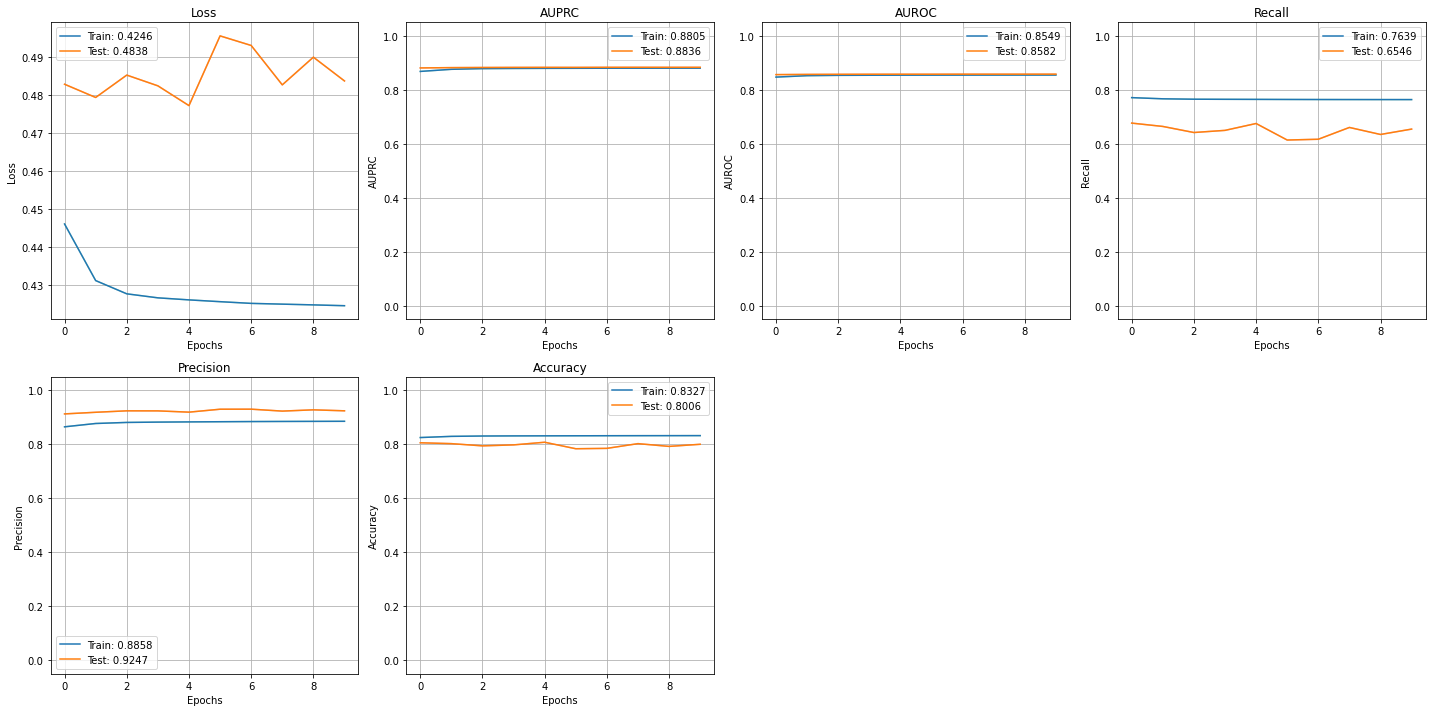

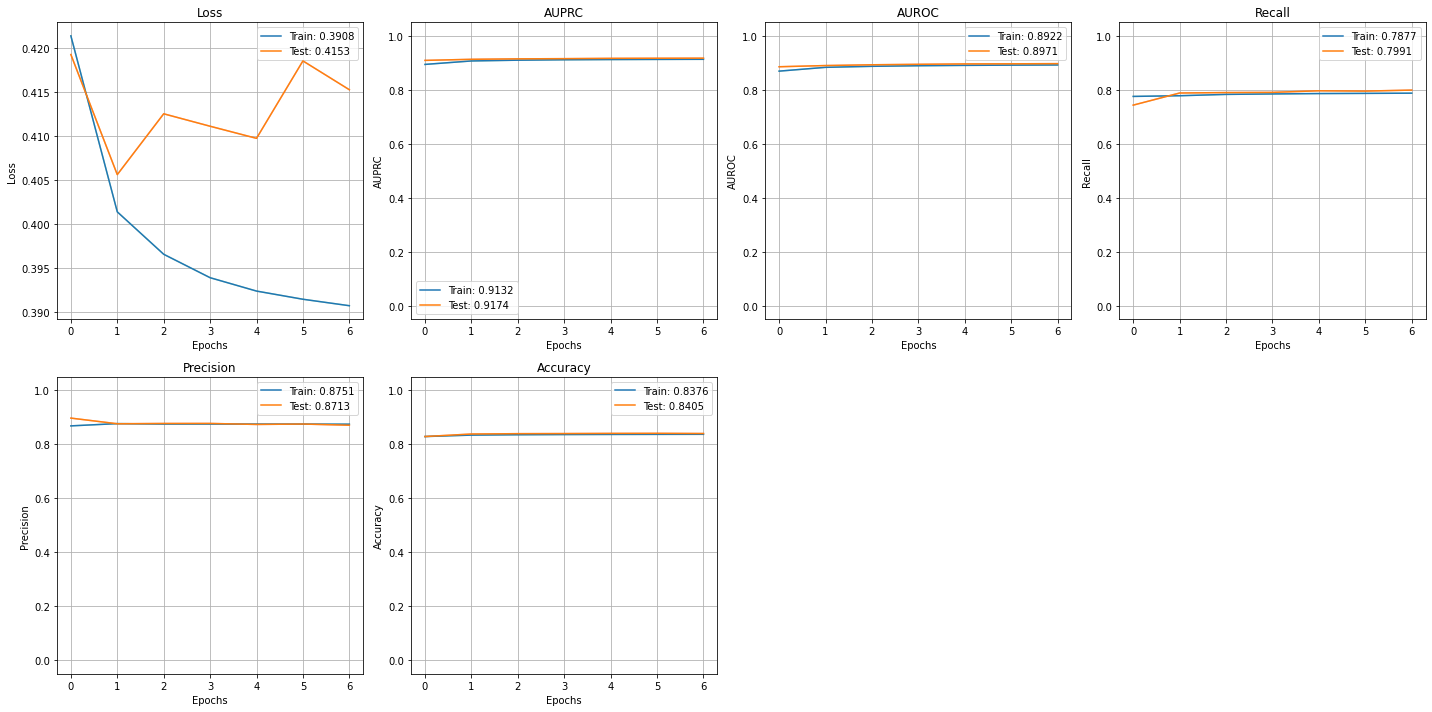

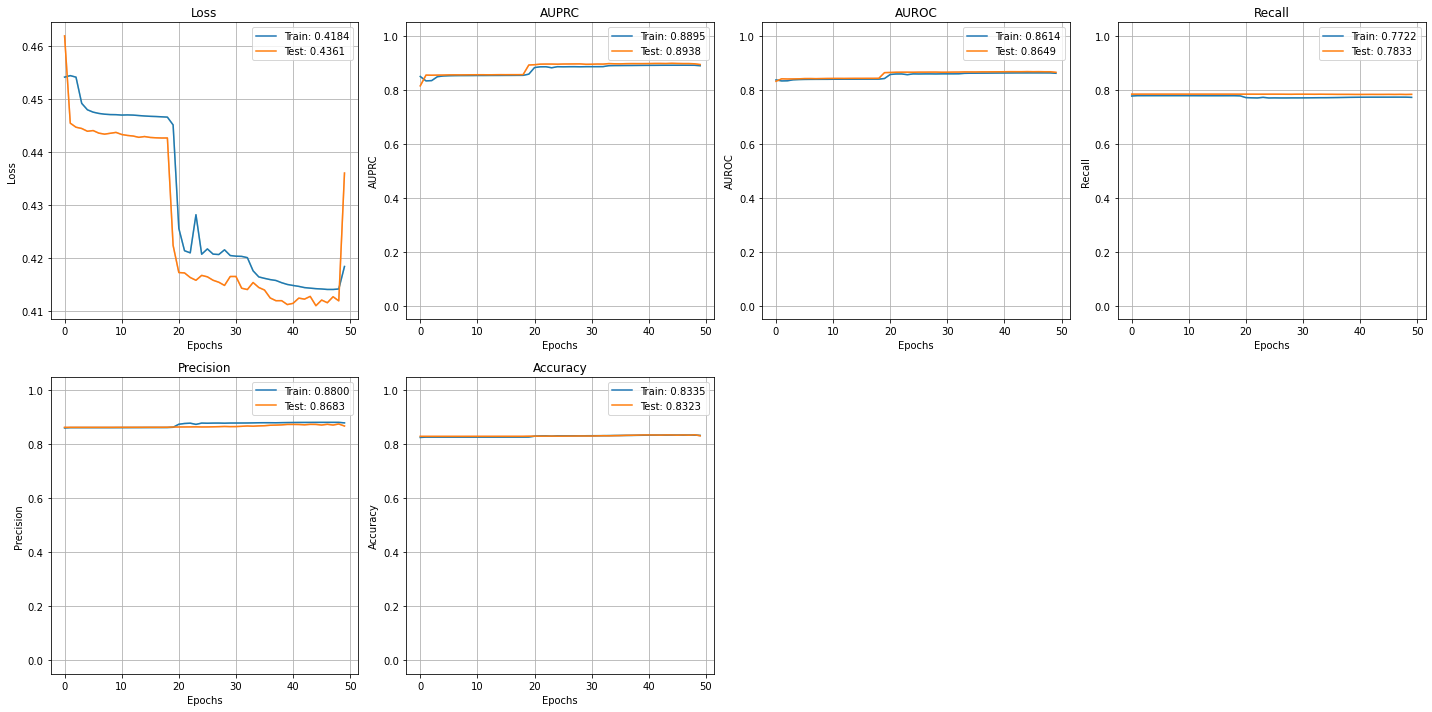

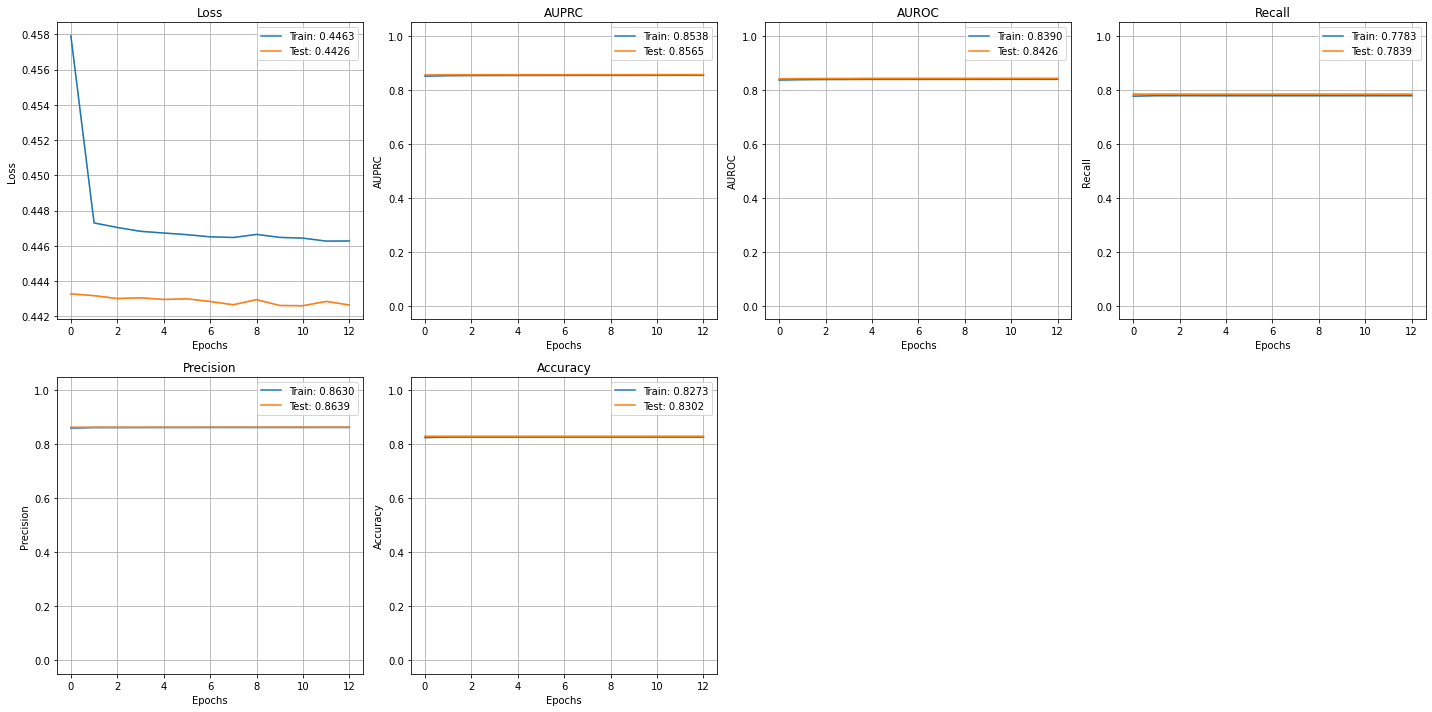

In [17]:
from plot_keras_history import plot_history

for history in histories.values():
    plot_history(history)

## Displaying results of various embedding methods

First we covert the histories into an homogeneous report:

In [18]:
from sanitize_ml_labels import sanitize_ml_labels

report = []
for (model, method), history in histories.items():
    last_epoch = history.iloc[-1].to_dict()
    sanitize = {
        sanitize_ml_labels(label):value
        for label, value in last_epoch.items()
        if label not in ("lr")
    }
    training = {
        key:val
        for key, val in sanitize.items()
        if "Val" not in key
    }
    validation = {
        sanitize_ml_labels(key.replace("Val ", "")):val
        for key, val in sanitize.items()
        if "Val" in key
    }

    report.append({
        "run":"training",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **training
    })
    report.append({
        "run":"validation",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **validation
    })

report = pd.DataFrame(report)

## Training link prediction on some other models
Here we execute the link prediction using Random Forests, Decision Trees and Logistic Regression so to have a good comparison.

In [19]:
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import cpu_count

kwargs = {
#     "DecisionTreeClassifier":dict(
#         max_depth=30,
#         random_state=42
#     ),
#     "RandomForestClassifier":dict(
#         n_estimators=500,
#         max_depth=30,
#         n_jobs=cpu_count(),
#         random_state=42
#     ),
#     "LogisticRegression":dict(
#         random_state=42,
#         max_iter=1000
#     )
}

def metric_report(y_true, y_pred):
    metrics = (
        roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
    )
    return {
        sanitize_ml_labels(metric.__name__):metric(y_true, y_pred)
        for metric in metrics
    }

metrics_reports_path = "classical_link_prediction/linear_models_reports.csv"
if os.path.exists(metrics_reports_path):
    metrics_reports = pd.read_csv(metrics_reports_path)
else:
    metrics_reports = []

    for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
        for model_builder in tqdm((DecisionTreeClassifier, RandomForestClassifier, LogisticRegression), desc="Model", leave=False):
            model = model_builder(**kwargs[model_builder.__name__])
            train_x, train_y = train
            valid_x, valid_y = valid
            model.fit(train_x, train_y)
            train_y_pred = model.predict(train_x)
            valid_y_pred = model.predict(valid_x)
            metrics_reports.append({
                "run":"training",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(train_y, train_y_pred)
            })
            metrics_reports.append({
                "run":"validation",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(valid_y, valid_y_pred)
            })

    metrics_reports = pd.DataFrame(metrics_reports)
    metrics_reports.to_csv(metrics_reports_path, index=None)


KeyError: 'DecisionTreeClassifier'

## Merging reports

In [ ]:
all_reports = pd.concat([
    metrics_reports,
    report
])

all_reports.to_csv("classical_link_prediction/all_reports.csv", index=None)

In [ ]:
from barplots import barplots
from IPython.display import display
from PIL import Image

# show_standard_deviation is False because there is only one holdout!
barplots(
    all_reports,
    ["run", "method", "embedding_model", "model"],
    path = 'barplots/{feature}.jpg',
    show_standard_deviation=False,
    height=5,
    subplots=True,
    plots_per_row=1
)

for barplot_path in glob("barplots/*"):
    display(Image.open(barplot_path))

In [ ]:
from scipy.stats import wilcoxon

scored_per_method = [
    (group, x["AUPRC"].values)
    for group, x in list(all_reports[["AUPRC", "method"]].groupby("method"))
]

for i, (method1, scores1) in enumerate(scored_per_method):
    for method2, scores2 in scored_per_method[i+1:]:
        print(
            method1, method2, wilcoxon(scores1, scores2)
        )